In [22]:
## Cell 1: Setup and Import Libraries

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, SpatialDropout1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os # <-- THIS LINE FIXES THE ERROR

print("✅ Libraries imported successfully.")
print(f"TensorFlow Version: {tf.__version__}")

✅ Libraries imported successfully.
TensorFlow Version: 2.20.0


In [24]:
## Cell 2: Configuration and Hyperparameters

# --- Dataset File Paths ---
# !! Make sure these CSV files are in the same directory as your notebook !!
file_paths = {
    'csic': 'csic_2010.csv',
    'sqli': 'SQL_Injection_Dataset.csv',
    'xss': 'XSS_dataset.csv',
    'url': 'malicious_urls.csv'
}

# --- Model Hyperparameters ---
# Vocabulary size: The maximum number of unique characters to consider.
MAX_FEATURES = 10000
# Sequence length: The fixed length for all input sequences. Longer ones are truncated, shorter ones are padded.
MAX_LEN = 250
# Embedding dimension: The size of the dense vector for each character.
EMBEDDING_DIM = 128
# GRU units: The number of neurons in the GRU layer, representing the model's memory capacity.
GRU_UNITS = 128

# --- Training Parameters ---
BATCH_SIZE = 256
EPOCHS = 5 # Start with 5; you can increase this for potentially better performance.

print("✅ Configuration loaded.")

✅ Configuration loaded.


In [25]:
## Cell 3: Load, Combine, and Prepare Datasets

df_master = None
try:
    print("\n🔄 Loading and processing datasets...")
    # (Code for loading and standardizing all four datasets)
    df_csic = pd.read_csv(file_paths['csic'])
    df_sqli = pd.read_csv(file_paths['sqli'])
    df_xss = pd.read_csv(file_paths['xss'])
    df_url = pd.read_csv(file_paths['url'])
    print("... all datasets loaded successfully.")

    # Standardize CSIC 2010
    df1 = df_csic[['content', 'classification']].copy()
    df1.rename(columns={'content': 'payload', 'classification': 'label'}, inplace=True)
    df1['label'] = df1['label'].apply(lambda x: 1 if str(x).lower() == 'anomalous' else 0)

    # Standardize SQL Injection
    df2 = df_sqli[['Query', 'Label']].copy()
    df2.rename(columns={'Query': 'payload', 'Label': 'label'}, inplace=True)

    # Standardize Cross-Site Scripting (XSS)
    df3 = df_xss[['Sentence', 'Label']].copy()
    df3.rename(columns={'Sentence': 'payload', 'Label': 'label'}, inplace=True)

    # Standardize Malicious URLs
    df4 = df_url[['url', 'type']].copy()
    df4.rename(columns={'url': 'payload', 'type': 'label'}, inplace=True)
    df4['label'] = df4['label'].apply(lambda x: 0 if x == 'benign' else 1)

    # Combine, Clean, and Shuffle
    df_combined = pd.concat([df1, df2, df3, df4], ignore_index=True)
    df_combined.dropna(inplace=True)
    df_combined = df_combined[df_combined['payload'].astype(str).str.len() > 1]
    df_master = df_combined.sample(frac=1, random_state=42).reset_index(drop=True)

    print("\n--- ✅ Master Dataset Created Successfully ---")
    print(f"Total samples: {len(df_master):,}")
    print("Final Class Distribution:\n", df_master['label'].value_counts())
    
    # --- SAVE THE DATASET TO A FOLDER ---
    output_folder = 'prepared_dataset'
    output_filename = 'master_web_attack_dataset.csv'
    output_path = os.path.join(output_folder, output_filename)

    # Create the folder if it doesn't already exist
    os.makedirs(output_folder, exist_ok=True)

    # Save the final dataframe to the specified path
    df_master.to_csv(output_path, index=False)
    print(f"\n💾 Master dataset successfully saved to: '{output_path}'")

except (FileNotFoundError, KeyError) as e:
    print(f"\n❌ ERROR during data preparation: {e}")
    print("Please check that all CSV files exist and that the column names are correct.")


🔄 Loading and processing datasets...
... all datasets loaded successfully.

--- ✅ Master Dataset Created Successfully ---
Total samples: 713,644
Final Class Distribution:
 label
0    471816
1    241828
Name: count, dtype: int64

💾 Master dataset successfully saved to: 'prepared_dataset/master_web_attack_dataset.csv'


In [26]:
## Cell 4: Preprocessing - Tokenization and Padding

if df_master is not None and not df_master.empty:
    print("\n🔄 Preprocessing data: Converting text to numerical sequences...")

    # Extract payloads and labels from the master dataframe
    payloads = df_master['payload'].astype(str).values
    labels = df_master['label'].values

    # 1. Tokenization: Create a vocabulary of unique characters and convert each payload
    # into a sequence of corresponding integers.
    tokenizer = Tokenizer(num_words=MAX_FEATURES, char_level=True, oov_token='<OOV>')
    tokenizer.fit_on_texts(payloads)
    sequences = tokenizer.texts_to_sequences(payloads)

    # 2. Padding: Ensure all sequences have the same length by adding zeros to shorter ones.
    X = pad_sequences(sequences, maxlen=MAX_LEN)
    y = np.asarray(labels)

    print(f"Data tensor shape (X): {X.shape}")
    print(f"Label tensor shape (y): {y.shape}")
else:
    print("Skipping preprocessing because the master dataframe was not created successfully.")


🔄 Preprocessing data: Converting text to numerical sequences...
Data tensor shape (X): (713644, 250)
Label tensor shape (y): (713644,)


In [27]:
## Cell 5: Split Data into Training and Testing Sets

if 'X' in locals() and 'y' in locals():
    print("\n🔄 Splitting data into training and testing sets...")

    # stratify=y ensures the proportion of malicious vs. benign samples is the same
    # in both the training and testing sets, which is crucial for model performance.
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2, # Use 20% of the data for testing
        random_state=42, # For reproducible results
        stratify=y
    )

    print(f"Training samples: {len(X_train):,}")
    print(f"Testing samples:  {len(X_test):,}")
else:
    print("Skipping train-test split because data tensors (X, y) are not defined.")


🔄 Splitting data into training and testing sets...
Training samples: 570,915
Testing samples:  142,729


In [30]:
## Cell 6: Build the GRU Model Architecture (Modern Practice)

print("\n🧠 Building the GRU model...")

model = Sequential(name="GRU_Web_Threat_Detector")

# 1. Define the input layer explicitly (NEW WAY)
# This layer tells the model to expect integer sequences of length MAX_LEN.
model.add(tf.keras.Input(shape=(MAX_LEN,)))

# 2. Add the Embedding Layer (without input_shape)
# It automatically infers its input shape from the layer above.
model.add(Embedding(input_dim=MAX_FEATURES, output_dim=EMBEDDING_DIM))

# 3. Add the rest of the layers as before
model.add(SpatialDropout1D(0.4))
model.add(GRU(units=GRU_UNITS, dropout=0.4, recurrent_dropout=0.4))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

model.summary()


🧠 Building the GRU model...


Model: "GRU_Web_Threat_Detector"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 250, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_3             │ (None, 250, 128)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 128)            │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,379,201 (5.26 MB)

 Trainable params: 1,379,201 (5.26 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
## Cell 7: Train the Model

print("\n🚀 Starting model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    verbose=1
)
print("\n✅ Training complete.")

In [31]:
## Cell 7: Train the Model

print("\n🚀 Starting model training...")

# The `fit` method trains the model. It's the most computationally intensive step.
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1, # Uses 10% of training data to monitor for overfitting
    verbose=1
)

print("\n✅ Training complete.")


🚀 Starting model training...
Epoch 1/5
2008/2008 ━━━━━━━━━━━━━━━━━━━━ 341s 169ms/step - accuracy: 0.8954 - loss: 0.2683 - precision_3: 0.8691 - recall_3: 0.8143 - val_accuracy: 0.9429 - val_loss: 0.1595 - val_precision_3: 0.9164 - val_recall_3: 0.9124
Epoch 2/5
2008/2008 ━━━━━━━━━━━━━━━━━━━━ 326s 162ms/step - accuracy: 0.9369 - loss: 0.1774 - precision_3: 0.9263 - recall_3: 0.8845 - val_accuracy: 0.9563 - val_loss: 0.1307 - val_precision_3: 0.9584 - val_recall_3: 0.9085
Epoch 3/5
2008/2008 ━━━━━━━━━━━━━━━━━━━━ 313s 156ms/step - accuracy: 0.9525 - loss: 0.1360 - precision_3: 0.9454 - recall_3: 0.9128 - val_accuracy: 0.9634 - val_loss: 0.1063 - val_precision_3: 0.9635 - val_recall_3: 0.9257
Epoch 4/5
2008/2008 ━━━━━━━━━━━━━━━━━━━━ 313s 156ms/step - accuracy: 0.9623 - loss: 0.1102 - precision_3: 0.9570 - recall_3: 0.9307 - val_accuracy: 0.9709 - val_loss: 0.0873 - val_precision_3: 0.9675 - val_recall_3: 0.9447
Epoch 5/5
2008/2008 ━━━━━━━━━━━━━━━━━━━━ 313s 156ms/step - accuracy: 0.9673 - 

In [32]:
## Cell 8: Evaluate Model Performance

print("\n🧪 Evaluating model on the test set...")

# Get performance metrics on the unseen test data
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)

print(f"\n--- Test Set Performance ---")
print(f"Accuracy:  {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall:    {recall*100:.2f}%")
print(f"Loss:      {loss:.4f}")

# Generate predictions for the classification report
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

# Display a detailed classification report
print("\n📊 Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Benign (0)', 'Malicious (1)']))


🧪 Evaluating model on the test set...

--- Test Set Performance ---
Accuracy:  97.39%
Precision: 98.09%
Recall:    94.14%
Loss:      0.0777
4461/4461 ━━━━━━━━━━━━━━━━━━━━ 53s 12ms/step

📊 Classification Report:

               precision    recall  f1-score   support

   Benign (0)       0.97      0.99      0.98     94363
Malicious (1)       0.98      0.94      0.96     48366

     accuracy                           0.97    142729
    macro avg       0.98      0.97      0.97    142729
 weighted avg       0.97      0.97      0.97    142729




🤔 Confusion Matrix:



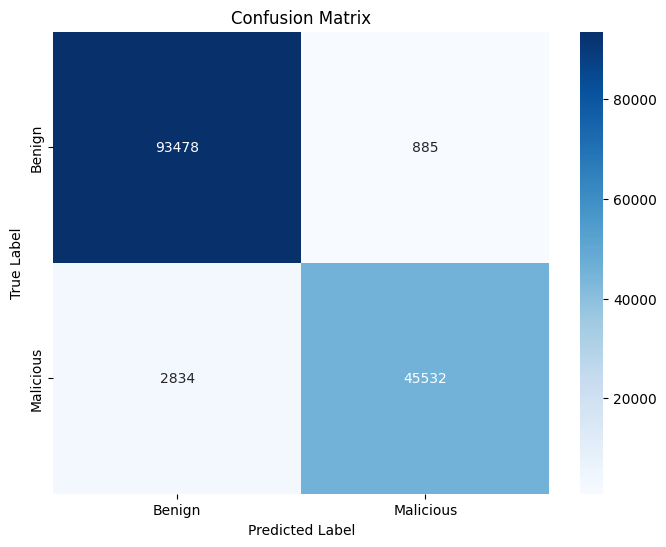

In [33]:
## Cell 9: Visualize Results - Confusion Matrix

print("\n🤔 Confusion Matrix:\n")
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True, # Show the numbers in the cells
    fmt='d',    # Format numbers as integers
    cmap='Blues',
    xticklabels=['Benign', 'Malicious'],
    yticklabels=['Benign', 'Malicious']
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

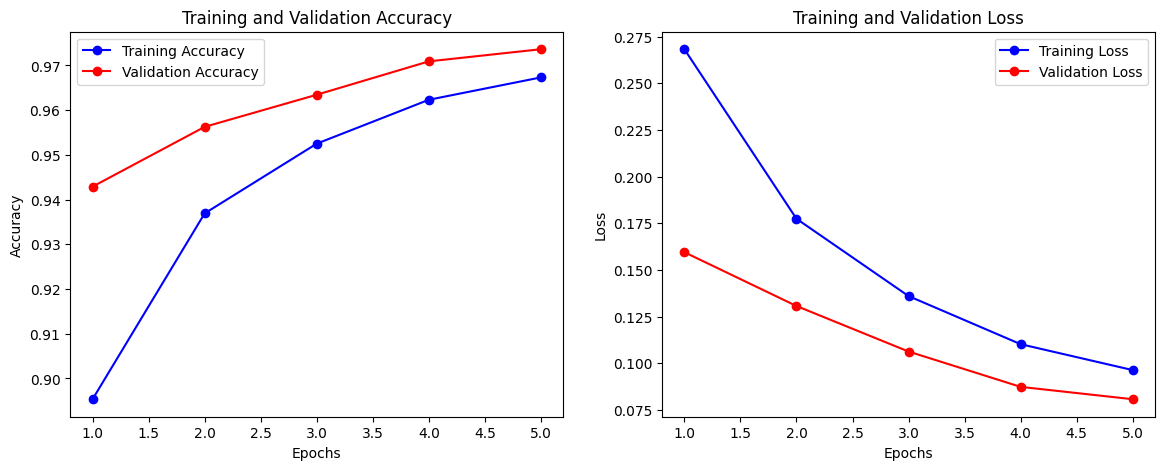

In [34]:
## Cell 10: Visualize Training History

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs_range, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, 'bo-', label='Training Loss')
plt.plot(epochs_range, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [35]:
## Cell 11: Real-Time Prediction Function

def predict_threat(payload_string):
    """
    Takes a raw string, preprocesses it, and predicts if it's a threat.
    """
    # Preprocess the new string using the same tokenizer and padding
    seq = tokenizer.texts_to_sequences([payload_string])
    padded_seq = pad_sequences(seq, maxlen=MAX_LEN)

    # Get the prediction probability from the model
    prediction_prob = model.predict(padded_seq, verbose=0)[0][0]

    # Determine the result based on a 0.5 threshold
    verdict = "🚨 THREAT DETECTED 🚨" if prediction_prob > 0.5 else "✅ BENIGN ✅"

    print(f"\nInput: '{payload_string}'")
    print(f"Malicious Probability: {prediction_prob:.4f}")
    print(f"Verdict: {verdict}")

# --- Test with new, unseen samples ---
print("\n🕵️--- Real-Time Threat Detection Test ---")
predict_threat("<script>alert('xss attack');</script>")
predict_threat("1' OR '1'='1'; --")
predict_threat("https://www.google.com/search?q=normal+search")
predict_threat("../../../etc/passwd")


🕵️--- Real-Time Threat Detection Test ---

Input: '<script>alert('xss attack');</script>'
Malicious Probability: 0.9982
Verdict: 🚨 THREAT DETECTED 🚨

Input: '1' OR '1'='1'; --'
Malicious Probability: 0.9999
Verdict: 🚨 THREAT DETECTED 🚨

Input: 'https://www.google.com/search?q=normal+search'
Malicious Probability: 0.9995
Verdict: 🚨 THREAT DETECTED 🚨

Input: '../../../etc/passwd'
Malicious Probability: 0.0146
Verdict: ✅ BENIGN ✅
